In [1]:
#IMPORTS
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [2]:
# DEEP Q NETWORK 
class DeepQNetwork(nn.Module):  
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims,         # init the network with parameters
                 n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')
        self.to(self.device)

    def forward(self,state):                       # returns Q values corresponding to  # various actions available in state .
        x = F.relu(self.fc1(state.float()))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)
        return actions

In [3]:
#AGENT 
class Agent(object):
    def __init__(self, gamma, epsilon, alpha, input_dims, batch_size, n_actions,   # init agent with parameters
                 max_mem_size=100000, eps_min=0.01, eps_decay= 5e-3):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.alpha = alpha
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.mem_size = max_mem_size #replay memory parameters
        self.batch_size = batch_size
        self.mem_counter = 0   # counter to index of the element to replace in replay memory
        
        self.Q_eval = DeepQNetwork(alpha, n_actions=self.n_actions,                 # the running Q network
                              input_dims=input_dims, fc1_dims=256, fc2_dims=256) 
        
        
        self.Q_train= DeepQNetwork(alpha, n_actions=self.n_actions, 
                                   input_dims=input_dims, fc1_dims=256, fc2_dims=256)  # the target Q network
        self.Q_train.load_state_dict(self.Q_eval.state_dict())   #similar Q networks
        self.Q_train.eval()     # setting training net to eval mode
        
       
        self.state_memory = np.zeros((self.mem_size, *input_dims),dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims),dtype=np.float32)               # replay memory in form of for arrays
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)    #stores action 
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)  #stores reward
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)   # stores if the state is final state
    
    def storeTransition(self, state, action, reward, next_state, done):   # maintains n recent experience in a fixed size replay memory 
        index = self.mem_counter % self.mem_size   # to see which element to remove from the memory.
        self.state_memory[index] = state 
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = next_state
        self.terminal_memory[index] = done
        self.mem_counter += 1
        
    def chooseAction(self, observation):
        rand = np.random.random()
        if rand>self.epsilon:
            state=T.tensor([observation]).to(self.Q_eval.device)    # convert observation to tensor
            actions=self.Q_eval.forward(state) # Q values corresponding to different actions
            action=T.argmax(actions)
        else:
            action = np.random.choice(self.action_space)
        return action
    
    
    def learn(self):#trains a batch of experiences
            if self.mem_counter<self.batch_size:
                return
            
            max_mem=min(self.mem_counter,self.mem_size)
            batch = np.random.choice(max_mem, self.batch_size)
            batch_index=np.arange(self.batch_size,dtype=np.int32)
            
            state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
            new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
            reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
            terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
            action_batch= self.action_memory[batch]
            
            self.Q_eval.optimizer.zero_grad()
            
            q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] # slicing to get the values 
                                                                                # corresponding to taken actions only.
            
            q_next = self.Q_train.forward(new_state_batch)
            q_next[terminal_batch]=0.0
            
            q_target= reward_batch+ self.gamma * T.max(q_next,dim=1)[0]   #Bellman equation

            loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
            loss.backward()
            self.Q_eval.optimizer.step()
            
            if self.epsilon > self.eps_min :
                self.epsilon-=self.eps_decay  

In [4]:
import pandas as pd
df=pd.read_csv('data/GOOG (1).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,153.723801,160.309128,152.179596,160.060059,160.060059,7248066
1,2009-01-05,159.900650,165.001541,156.911850,163.412491,163.412491,9814650
2,2009-01-06,165.868286,169.763687,162.585587,166.406265,166.406265,12898566
3,2009-01-07,163.546982,164.837143,158.779861,160.403763,160.403763,9022693
4,2009-01-08,158.545731,161.987823,158.077484,161.987823,161.987823,7228393


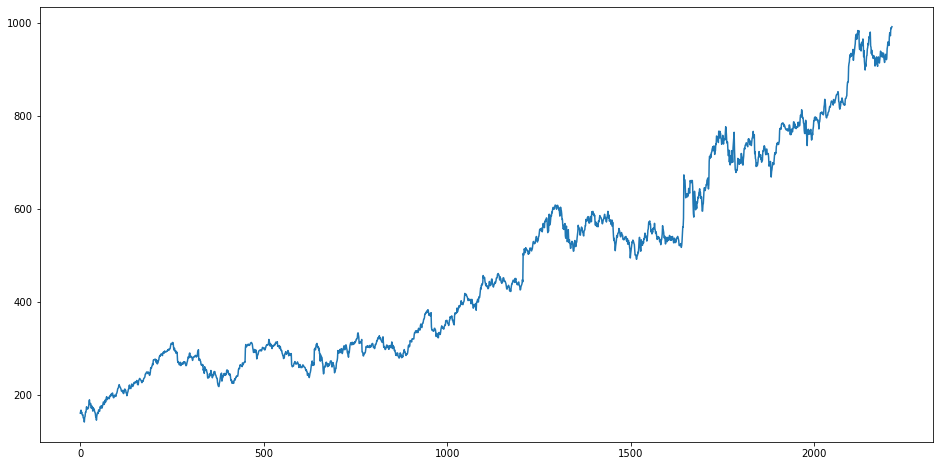

In [5]:
import matplotlib.pyplot as plt

total=df.shape[0]
V = df['Adj Close']
train_size= (int)(total*0.8)#divide 80 20 for train test
train=V[:train_size]
test=V[train_size:]
test_vec=(list)(test)
train_vec=(list)(train)
plt.figure(figsize=(16,8))
plt.plot(np.arange(train_size),train)

In [6]:
def upd_state(data,time,action,curr_stocks_bought,n,transaction_count,total_money,Max_transactions):
    state= np.array(data[time-n+1:time])
    curr_val= total_money+curr_stocks_bought*data[time-1]
    if(action==0):
        curr_stocks_bought += ((total_money)/(Max_transactions - transaction_count))/data[time-1]
        total_money-= ((total_money)/(max_trans-transaction_count))
        transaction_count+=1
    elif(action==1):
        total_money+=(data[time-1]*curr_stocks_bought)
        curr_stocks_bought=0
        transaction_count=0
    next_val=total_money+curr_stocks_bought*data[time]
    if(data[time]>=data[time-1]):
        opt_action=0
    if(data[time]<data[time-1]):
        opt_action=1       
    state=np.append(state,curr_stocks_bought)
    reward= (next_val-curr_val)
    return (reward,state,curr_stocks_bought,transaction_count,total_money,opt_action)

In [9]:
num_episodes=50
profits=[]
data=train_vec
data_size=len(data)
state_size= 50
steps_upd_target=20  # steps after which target network should be updated
max_trans =50
total_money=10000
agent=Agent(gamma=0.95, epsilon=1, alpha=0.001, input_dims=[state_size], batch_size=32, n_actions=3,   # initialises the agent
                 max_mem_size=1000, eps_min=0.01, eps_decay= 2e-5)
for ep in np.arange(num_episodes):
    
    time=state_size
    State=np.array(data[time-state_size+1:time],dtype=np.float32)
    State=np.append(State,0)
    curr_stocks_bought= (float)(0)
    transaction_count=0
    ep_reward=0
    total_money=10000
    dicti={0:"Buy",1:"Sell",2:"Hold"}
    while(time<data_size):
        action=agent.chooseAction(State)
        if(action==0 and transaction_count<max_trans):
            action=0
        elif(action==0 and transaction_count==max_trans):
            action=2
            
        reward,new_state,curr_stocks_bought,transaction_count,total_money,opt_action=upd_state(data,time,action,curr_stocks_bought,state_size,transaction_count,total_money,max_trans)
        agent.storeTransition(State, action, reward, new_state,0)
        agent.learn()
        State=new_state
        ep_reward+=reward
        if(time%steps_upd_target==0):
             agent.Q_train.load_state_dict(agent.Q_eval.state_dict())
        time+=1    
#         print(" TIME = ",time,"Action Taken = ",dicti[(int)(action)],"Action Expected =",dicti[opt_action],"Reward = ",reward)
    
    
    profits.append(ep_reward)
    net= total_money+curr_stocks_bought*data[-1]
    print("EPISODE:",ep+1,"Episode Reward =",ep_reward," Net Amt=",net)
        
        
        
    



EPISODE: 1 Episode Reward = 547.9957688734976  Net Amt= 10547.995768873498
EPISODE: 2 Episode Reward = 567.5675311962896  Net Amt= 10567.56753119629
EPISODE: 3 Episode Reward = 873.3870331992784  Net Amt= 10873.387033199278
EPISODE: 4 Episode Reward = -9.836917372022072  Net Amt= 9990.163082627978
EPISODE: 5 Episode Reward = 223.7128235471173  Net Amt= 10223.712823547117
EPISODE: 6 Episode Reward = 424.5178994258349  Net Amt= 10424.517899425835
EPISODE: 7 Episode Reward = 512.0568701167467  Net Amt= 10512.056870116747
EPISODE: 8 Episode Reward = 1112.6358977767777  Net Amt= 11112.635897776778
EPISODE: 9 Episode Reward = 999.6066893116367  Net Amt= 10999.606689311637
EPISODE: 10 Episode Reward = 284.3503037900464  Net Amt= 10284.350303790046
EPISODE: 11 Episode Reward = 884.9043015533298  Net Amt= 10884.90430155333
EPISODE: 12 Episode Reward = 1126.010895990934  Net Amt= 11126.010895990934
EPISODE: 13 Episode Reward = 2304.050644023422  Net Amt= 12304.050644023422
EPISODE: 14 Episode Re

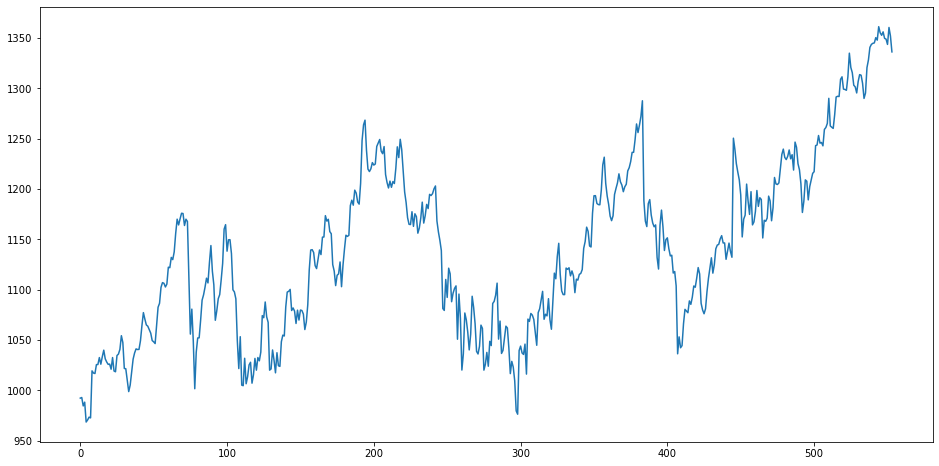

In [12]:
#Test Data
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(np.arange(data_size),data)

In [10]:
data=test_vec
data_size=len(data)
data_size
print(len(test_vec))
state_size= 50
max_trans =50
total_money=10000
time=state_size
State=np.array(data[time-state_size+1:time],dtype=np.float32)
State=np.append(State,0)
curr_stocks_bought= (float)(0)
transaction_count=0
Reward=0
dicti={0:"Buy",1:"Sell",2:"Hold"}
while(time<data_size):
        action=agent.chooseAction(State)
        if(action==0 and transaction_count<max_trans):
            action=0
        elif(action==0 and transaction_count==max_trans):
            action=2
            
        reward,new_state,curr_stocks_bought,transaction_count,total_money,opt_action=upd_state(data,time,action,curr_stocks_bought,state_size,transaction_count,total_money,max_trans)
        print(" TIME = ",time,"Action Taken = ",dicti[(int)(action)],"Action Expected =",dicti[opt_action])
            
        State=new_state
        Reward+=reward
        time+=1    
#         print(Reward)
    
    
net= total_money+curr_stocks_bought*data[-1]
print("Reward = ",Reward,"and net amount=",net)
        
        
        
    

554
 TIME =  50 Action Taken =  Buy Action Expected = Sell
 TIME =  51 Action Taken =  Buy Action Expected = Sell
 TIME =  52 Action Taken =  Buy Action Expected = Buy
 TIME =  53 Action Taken =  Buy Action Expected = Buy
 TIME =  54 Action Taken =  Buy Action Expected = Buy
 TIME =  55 Action Taken =  Buy Action Expected = Buy
 TIME =  56 Action Taken =  Buy Action Expected = Buy
 TIME =  57 Action Taken =  Buy Action Expected = Sell
 TIME =  58 Action Taken =  Buy Action Expected = Sell
 TIME =  59 Action Taken =  Buy Action Expected = Buy
 TIME =  60 Action Taken =  Buy Action Expected = Buy
 TIME =  61 Action Taken =  Buy Action Expected = Sell
 TIME =  62 Action Taken =  Buy Action Expected = Buy
 TIME =  63 Action Taken =  Buy Action Expected = Sell
 TIME =  64 Action Taken =  Buy Action Expected = Buy
 TIME =  65 Action Taken =  Buy Action Expected = Buy
 TIME =  66 Action Taken =  Buy Action Expected = Buy
 TIME =  67 Action Taken =  Buy Action Expected = Sell
 TIME =  68 Actio